In [1]:
from numpy import array, ones, concatenate, zeros
from numpy.random import random
import numpy as np
import pandas as pd
from pandas import read_csv, DataFrame
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from typing import Dict 

import logging 

In [2]:
df= pd.read_csv("DT.csv") 

df.head(10)

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
5,15728773,Male,27,58000,0
6,15598044,Female,27,84000,0
7,15694829,Female,32,150000,1
8,15600575,Male,25,33000,0
9,15727311,Female,35,65000,0


In [3]:
df.sample(5)

,User ID,Gender,Age,EstimatedSalary,Purchased
83,15711218,Male,35,88000,0
65,15718071,Male,24,58000,0
15,15697686,Male,29,80000,0
120,15811613,Female,36,75000,0
393,15635893,Male,60,42000,1


In [4]:
df.drop(columns=["User ID"], inplace=True)

In [5]:
target_col_name = "Purchased"

In [6]:
df["Gender"] = (df["Gender"] == "Male").astype(int)

In [7]:
df.head()

,Gender,Age,EstimatedSalary,Purchased
0,1,19,19000,0
1,1,35,20000,0
2,0,26,43000,0
3,0,27,57000,0
4,1,19,76000,0


In [8]:
logger = logging.getLogger(__name__)
logger.addHandler(logging.StreamHandler())
logger.setLevel("INFO")

In [9]:
df[df.isnull()] = 0

In [10]:
df[target_col_name].value_counts() 

Purchased
0    257
1    143
Name: count, dtype: int64

In [11]:
df[target_col_name].value_counts() / len(df) 

Purchased
0    0.6425
1    0.3575
Name: count, dtype: float64

In [14]:
from pydantic import BaseModel


class TrainParams(BaseModel):
    n_iters: int
    learning_rate: float
    eval_every: int

In [15]:
class LogisticRegression:
    def __init__(self, n_variables: int):
        # Инициализация весов модели случайными значениями
        self._weights = random(n_variables + 1)
        self._means = None  # Средние значения признаков
        self._stds = None   # Стандартные отклонения признаков
        
    
    def fit(self, x: DataFrame, y: array, train_params: TrainParams) -> None:
        # Вычисление средних значений и стандартных отклонений признаков
        self._means = train_x.mean(axis=0).values
        self._stds = train_x.std(axis=0).values

        logger.debug(f"x before preproc {x}")
        # Предобработка данных (масштабирование и добавление bias)
        x = self._preproc(x)
        logger.debug(f"x after preproc {x}")
        
        # Обучение модели с использованием градиентного спуска
        for iter_idx in range(train_params.n_iters):
            # Обновление весов модели на каждом шаге
            self._weights -= train_params.learning_rate * self.calculate_gradient(x, y)
            if iter_idx % train_params.eval_every == 0:
                # Предсказание на обучающем наборе и оценка метрик качества
                preds = self._predict(x)
                val_metrics = self.get_metrics(preds, y)
                logger.info(f"Iter {iter_idx}. Metrics: {val_metrics}")
    
    def calculate_gradient(self, x: array, y: array) -> array:
        # Вычисление градиента функции потерь по весам модели
        n_samples, n_features = x.shape
        
        pred = self._predict(x)
        
        gradients = []
        for feature_idx in range(n_features):
            # Вычисление градиента для каждого признака
            grads = (pred - y) * x[:, feature_idx]
            res = grads.mean()
            gradients.append(res)
        return array(gradients)
    
    
    def predict(self, x: DataFrame) -> array:
        # Предсказание меток классов на входных данных
        x = self._preproc(x)
        return self._predict(x)
    
    def _predict(self, x: array) -> array:
        # Вычисление вероятностей принадлежности к классу
        logits = (self._weights * x).sum(axis=1)
        return self._logistic_function(logits)
    
    def _logistic_function(self, logits: array) -> array:
        # Сигмоидная функция для преобразования в вероятности
        return 1 / (1 + np.exp(-logits)) 
    
    def _preproc(self, x: DataFrame) -> array:
        # Предобработка данных: масштабирование и добавление bias
        values = (x.values - self._means) / self._stds
        dummy_for_bias = ones((len(values), 1)) 
        values = concatenate([values, dummy_for_bias], axis=1)
        return values
    
    def get_metrics(self, preds: array, y: array) -> Dict[str, float]:
        # Вычисление метрик качества модели (accuracy, roc_auc, f1)
        preds_binary = preds > 0.5
        return {"accuracy": accuracy_score(y, preds_binary), 
                "roc_auc": roc_auc_score(y, preds), 
                "f1": f1_score(y, preds_binary)}

In [16]:
train, val = train_test_split(df)

In [17]:
train_params = TrainParams(n_iters=20000, learning_rate=1e-3, eval_every=1000)

train_x = train.drop(columns=target_col_name)
train_y = train[target_col_name].values

val_x = val.drop(columns=target_col_name)
val_y = val[target_col_name].values 

In [18]:
model = LogisticRegression(n_variables=len(train_x.columns))
model.fit(train_x, train_y, train_params)

Iter 0. Metrics: {'accuracy': 0.5966666666666667, 'roc_auc': 0.7289438667389483, 'f1': 0.5813148788927336}
Iter 1000. Metrics: {'accuracy': 0.6933333333333334, 'roc_auc': 0.8461879651076832, 'f1': 0.6515151515151515}
Iter 2000. Metrics: {'accuracy': 0.7866666666666666, 'roc_auc': 0.890197624562614, 'f1': 0.7288135593220338}
Iter 3000. Metrics: {'accuracy': 0.8, 'roc_auc': 0.9076437829579617, 'f1': 0.7247706422018347}
Iter 4000. Metrics: {'accuracy': 0.8166666666666667, 'roc_auc': 0.9162190133556749, 'f1': 0.7342995169082126}
Iter 5000. Metrics: {'accuracy': 0.8366666666666667, 'roc_auc': 0.9204573456212114, 'f1': 0.7562189054726368}
Iter 6000. Metrics: {'accuracy': 0.84, 'roc_auc': 0.921640136020896, 'f1': 0.7600000000000001}
Iter 7000. Metrics: {'accuracy': 0.8466666666666667, 'roc_auc': 0.9229707752205412, 'f1': 0.7628865979381445}
Iter 8000. Metrics: {'accuracy': 0.85, 'roc_auc': 0.9238085850869844, 'f1': 0.766839378238342}
Iter 9000. Metrics: {'accuracy': 0.85, 'roc_auc': 0.9248928

In [19]:
val_pred = model.predict(val_x) 
print(f"Метрики - {model.get_metrics(val_pred, val_y)}") 

Метрики - {'accuracy': 0.8, 'roc_auc': 0.9329166666666666, 'f1': 0.7142857142857143}


In [20]:
from collections import Counter 
Counter(val_pred >= 0.5) 

Counter({False: 70, True: 30})

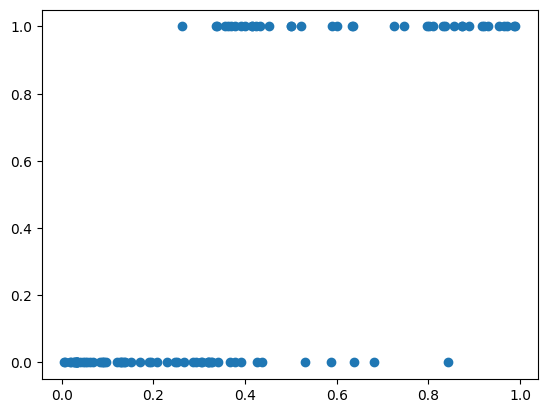

In [21]:
plt.scatter(val_pred, val_y) 